In [1]:
import os
import collections
import json
import torch
import numpy as np

import matplotlib.pyplot as plt
import glob

import PIL
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils import data
from torchvision import transforms

In [2]:
from datasets.VOC2012 import VOC2012_Dataset
from model.bisenet_v2 import BiSeNetV2

from utils.meter import AverageValueMeter
from utils.history import History
from utils import metrics

In [3]:
# Init Network, Loss and Optimizer
n_classes = 21
net = BiSeNetV2(n_classes=n_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
LABELS = [i for i in range(n_classes)]

Loaded pretrained weights for efficientnet-b0


In [4]:
# Init Training & Evalutaion Data Loader
img_size=(256, 256)
batch_size = 32
train_data = VOC2012_Dataset(
    root="G:/Codes/RealTime-Segementation/datasets/VOC2012", 
    split='train',
    img_size=img_size
)
eval_data = VOC2012_Dataset(
    root="G:/Codes/RealTime-Segementation/datasets/VOC2012", 
    split='val',
    img_size=img_size
)
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
eval_loader  = data.DataLoader(eval_data, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(eval_loader))

46
46


In [5]:
def train(net, train_loader, criterion, optimizer, pbar):
    pbar.n = 0
    pbar.last_print_n = 0 
    pbar.refresh()
    loss_meter = AverageValueMeter()
    history = History()
    net.train()
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        history.add_record('train_loss', loss.item())
        loss_meter.add(loss.item())

        pbar.update()
        pbar.set_postfix({'train_loss': f'{loss_meter.value()[0]:.4f}'})
    return history

In [6]:
def val(net, eval_loader, criterion, pbar):
    pbar.n = 0
    pbar.last_print_n = 0 
    pbar.refresh()
    loss_meter = AverageValueMeter()
    miou_meter = AverageValueMeter()
    pacc_meter = AverageValueMeter()
    history = History()
    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(eval_loader):
            outputs = net(inputs)
            preds = torch.argmax(outputs, dim=1)
            # Metrics
            loss = criterion(outputs, labels)
            miou = metrics.iou(preds.numpy(), labels.numpy(), labels=LABELS)
            pacc = metrics.pixel_accuracy(preds.numpy(), labels.numpy(), labels=LABELS)
            
            loss_meter.add(loss.item())
            miou_meter.add(miou)
            pacc_meter.add(pacc)
            
            pbar.set_postfix({
                'val_loss': f'{loss_meter.value()[0]:.4f}',
                'mIoU': f'{miou_meter.value()[0]:.4f}',
                'pix_acc': f'{pacc_meter.value()[0]:.4f}',
            })
            pbar.update()
    history.add_record('val_loss', loss_meter.value()[0])
    history.add_record('mIoU', miou_meter.value()[0])
    history.add_record('pixel_accuracy', pacc_meter.value()[0])
    return history

In [7]:
# Trial Run for Training
n_epochs = 50
n_train_steps = len(train_loader)
n_eval_steps = len(eval_loader)
pbar_train = tqdm(total=n_train_steps)
pbar_eval = tqdm(total=n_eval_steps)
train_history = History()
eval_history = History()
for epoch in range(1, n_epochs+1):
    ### Train
    pbar_train.set_description("{:^10} ({}/{})".format("Train", epoch, n_epochs))
    _history = train(net, train_loader, criterion, optimizer, pbar_train)
    train_history.append_history(_history)
    ### Val
    if epoch == 1 or epoch % 5 == 0:
        pbar_eval.set_description("{:^10} ({}/{})".format("Val", epoch, n_epochs))
        _history = val(net, eval_loader, criterion, pbar_eval)
        eval_history.append_history(_history)
pbar_train.close()
pbar_eval.close()

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

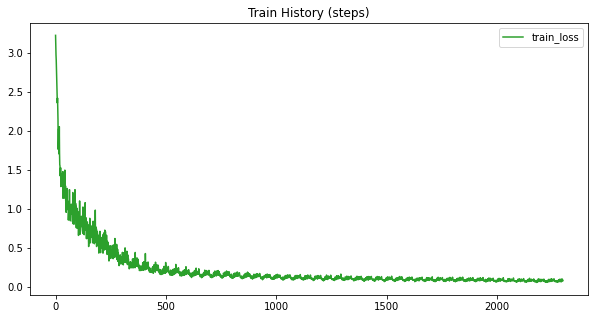

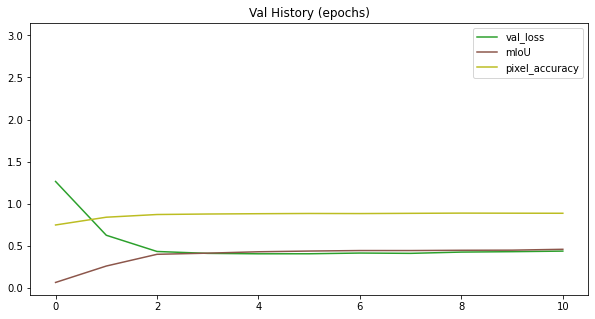

In [8]:
train_history.plot("Train History (steps)")
eval_history.plot("Val History (epochs)")

In [14]:
print(eval_history.data['mIoU'])

[0.06362371711160514, 0.25864842587285636, 0.3980659325622202, 0.4116919090717084, 0.4281819740231063, 0.43665405514868416, 0.4427314731606212, 0.4426630164785382, 0.4459434276423159, 0.44738776187269796, 0.45758757806970296]


In [9]:
save_path = "weights/bisenet.pth"
torch.save(net.state_dict(), save_path)
print(f"Write model to {save_path}")

Write model to weights/bisenet.pth


In [10]:
save_path = "weights/bisenet.pth"
net = BiSeNetV2(n_classes=21)
net.load_state_dict(torch.load(save_path))
net.eval()
print()

Loaded pretrained weights for efficientnet-b0



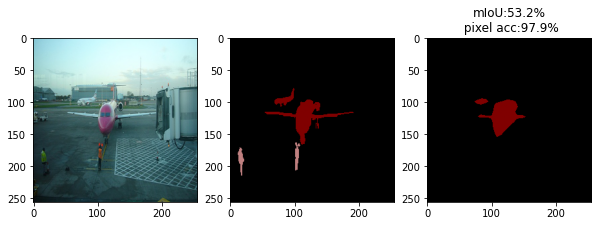

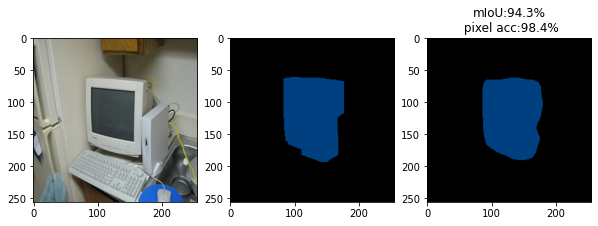

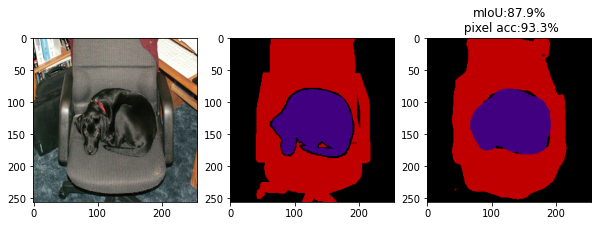

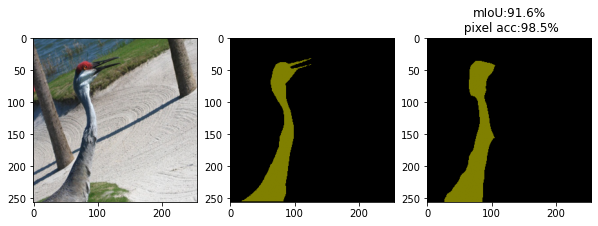

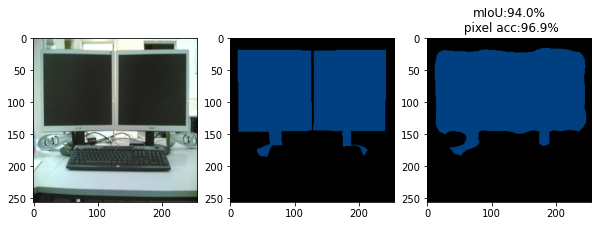

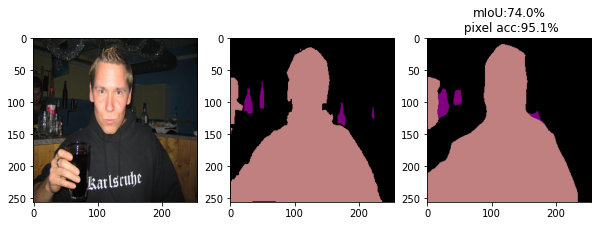

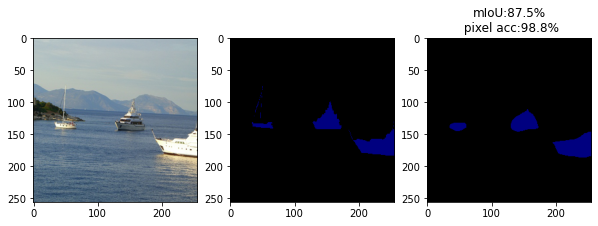

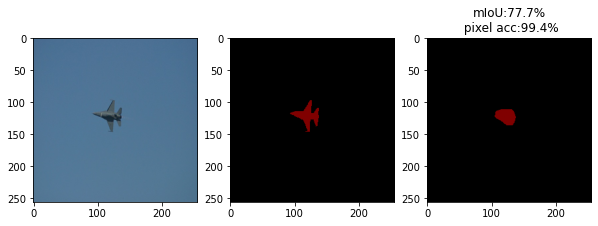

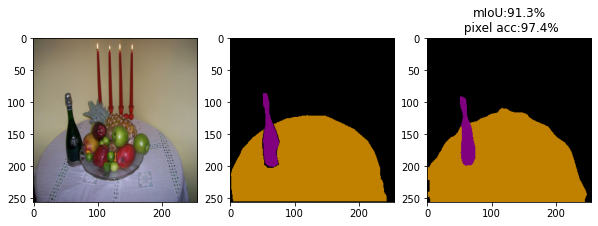

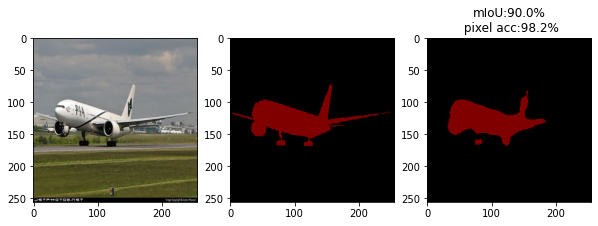

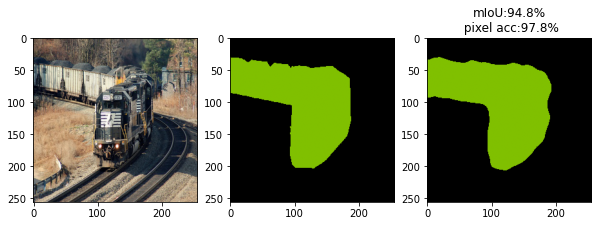

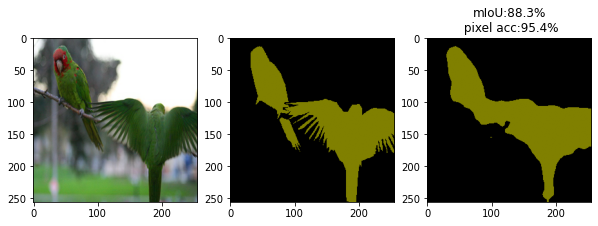

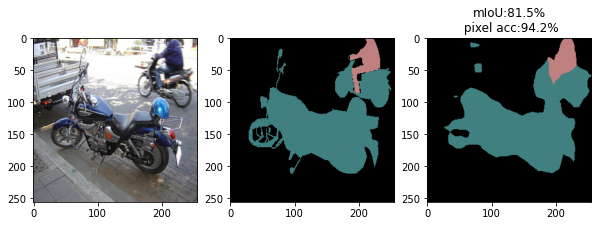

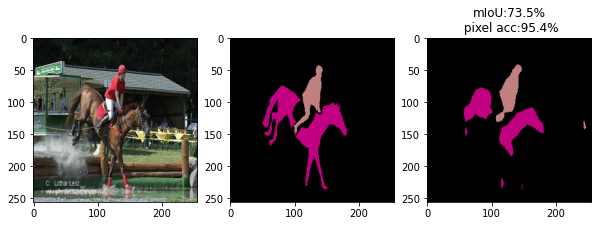

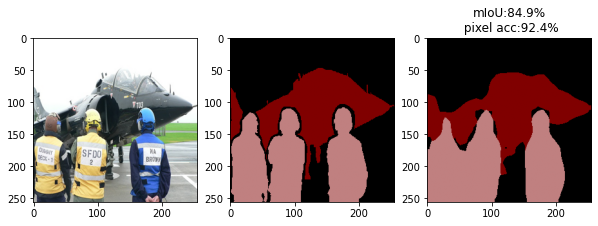

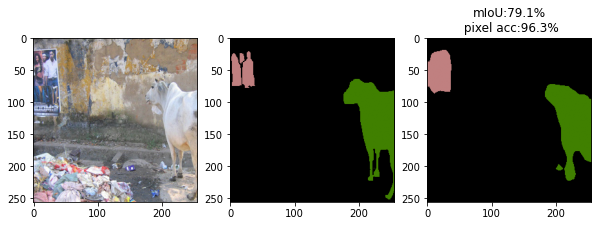

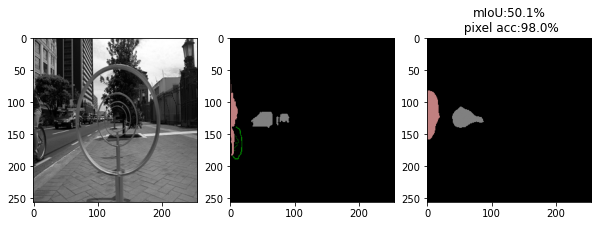

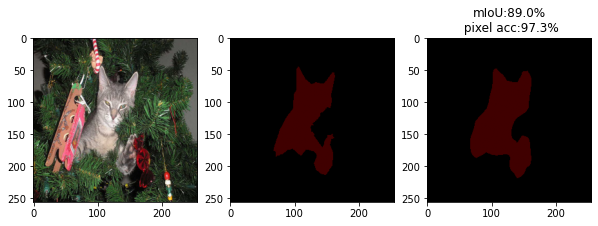

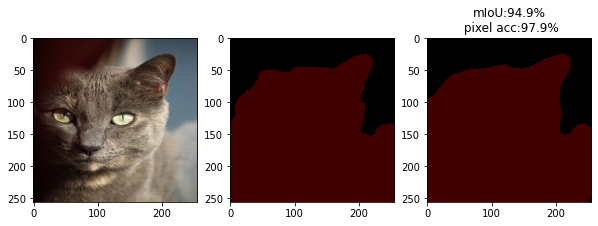

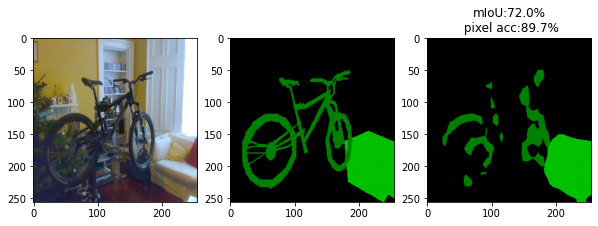

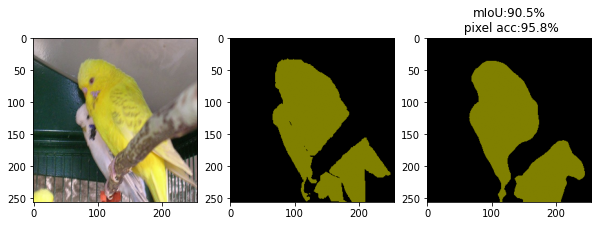

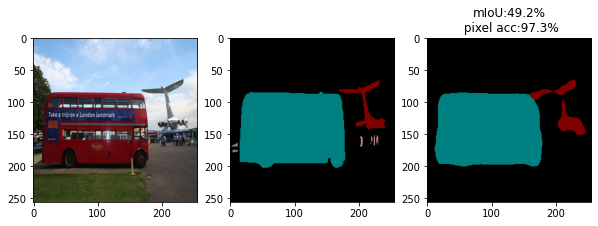

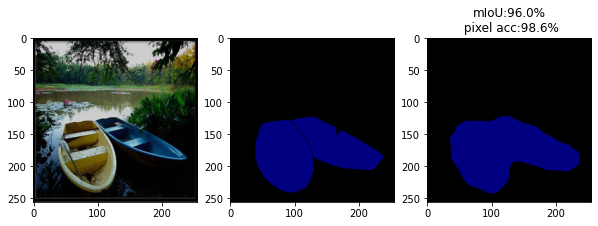

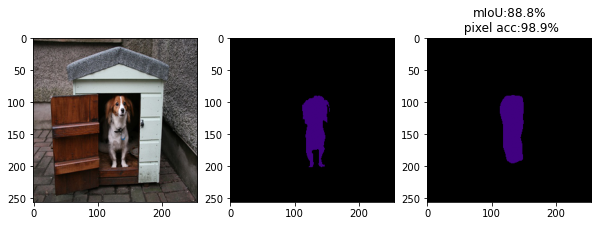

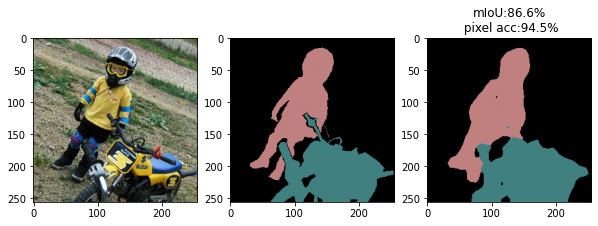

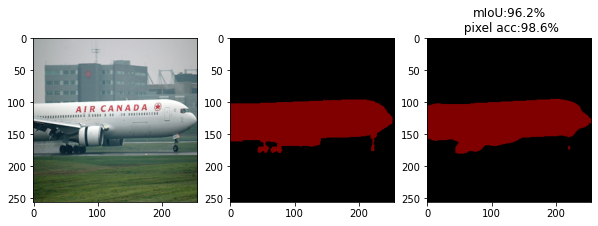

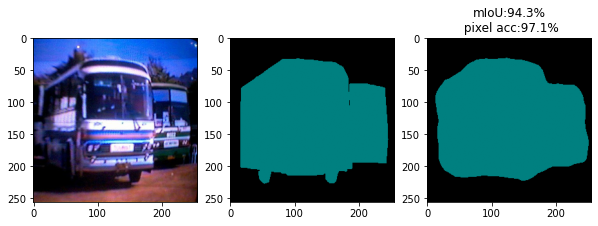

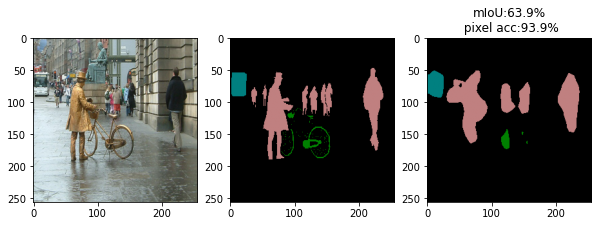

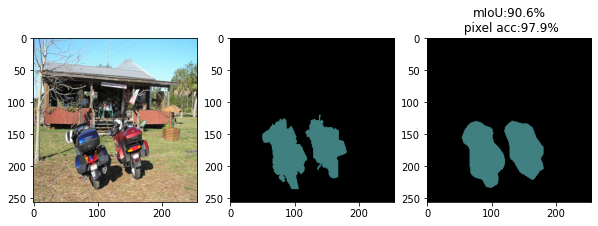

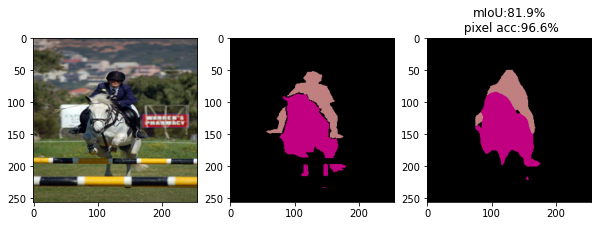

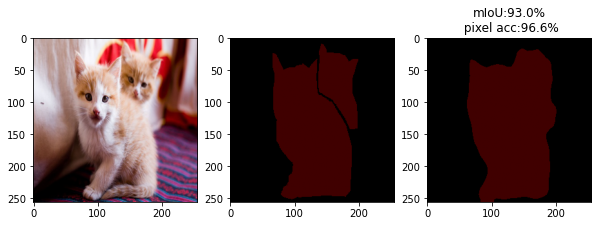

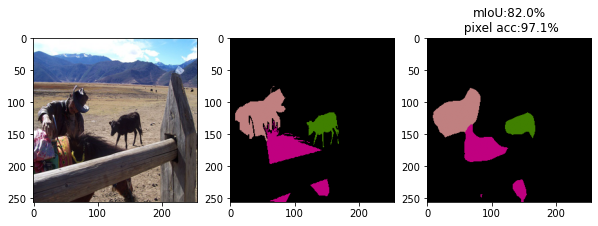

In [11]:
# Inference
with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_loader):
        outs = net(inputs)
        break
for k in range(batch_size):
    img = VOC2012_Dataset.denormalize(inputs[k]).numpy().transpose([1,2,0])
    preds = torch.argmax(outs, dim=1)
    # Metrics
    miou = metrics.iou(preds.numpy()[k], labels.numpy()[k], labels=LABELS)
    pacc = metrics.pixel_accuracy(preds.numpy()[k], labels.numpy()[k], labels=LABELS)
    # For Plot
    label = VOC2012_Dataset.decode_segmap(labels.numpy()[k])
    pred = VOC2012_Dataset.decode_segmap(preds.numpy()[k])
    plt.figure(figsize=(10,10))
    plt.subplot(131), plt.imshow(img)
    plt.subplot(132), plt.imshow(label)
    plt.subplot(133), plt.imshow(pred), plt.title(f"mIoU:{miou*100:.1f}%\n pixel acc:{pacc*100:.1f}%")
    plt.show()

In [12]:
print(f'Overall mIoU: {metrics.iou(preds.numpy(), labels.numpy(), labels=LABELS)*100:.1f}%')
print(f'Overall Pixel Accuracy: {metrics.pixel_accuracy(preds.numpy(), labels.numpy(), labels=LABELS)*100:.1f}%')

Overall mIoU: 81.7%
Overall Pixel Accuracy: 96.6%
